# Ансамбли. Бустинг.

## ЗАДАНИЕ I. ДОПОЛНИТЕЛЬНОЕ

**Дано**: набор данных из системы поискового антиспама.

**Требуется**: сравнить классификаторы, основанные на алгоритмических композициях, с классическими алгоритмами классификации (SVM, логистическая регрессия) и нейросетями (двуслойный персептрон).

1. Скачать данные и запустить шаблон кода на python:
```
$ python compos.py -h
$ python compos.py -tr spam.train.txt -te spam.test.txt
```
2. Подобрать параметры трёх алгоритмических композиций (RF, Adaboost, GBM), чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон.

2*. Построить графики качества классификации в зависимости от параметров алгоритмов (XGBoost, dart, LightGBM и CatBoost)

3. Построить графики качества классификации в зависимости от числа базовых моделей.

In [10]:
!python compos.py -h

usage: compos.py [-h] [-tr TRAIN] [-te TEST] [-t TREES] [-fp FEATURES_PERCENT]

Random Forest Tutorial

optional arguments:
  -h, --help            show this help message and exit
  -tr TRAIN, --train TRAIN
                        Train file name
  -te TEST, --test TEST
                        Test file name
  -t TREES, --trees TREES
                        Number of trees in random forest
  -fp FEATURES_PERCENT, --features_percent FEATURES_PERCENT
                        Percent of features in each tree


In [11]:
!python compos.py -tr spam.train.txt -te spam.test.txt

Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.54760   0.87998   0.67509      2033
        1.0    0.96406   0.81578   0.88374      8023

avg / total    0.87986   0.82876   0.84156     10056
final score    0.75583   0.84788   0.77942     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.42450   0.58173      2033
        1.0    0.87174   0.99115   0.92762      8023

avg / total    0.88230   0.87659   0.85769     10056
final score    0.89786   0.70782   0.75467     10056

Gradient Boosting Machine :
             precision    recall  f1-score   support

        0.0    0.67793   0.84899   0.75388      2033
        1.0    0.95912   0.89779   0.92744      8023

avg / total    0.90227   0.88793   0.89235     10056
final score    0.81852   0.87339   0.84066     10056

SVM :
             precision  

In [47]:
import numpy as np
import matplotlib.pyplot as pl

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support

#from sklearn.utils.multiclass import unique_labels
#from sklearn.decomposition import PCA


from compos import visualize_data, classification_report


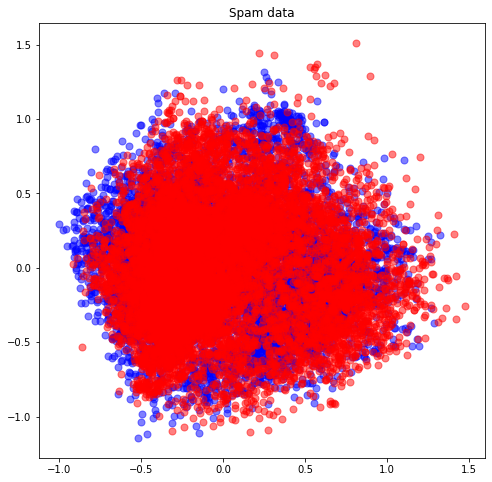

In [48]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

total_data = np.concatenate(([train_data, test_data]), axis=0)

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

#number_of_features = len(train_data[0, 1:])

In [28]:
X_train.shape, X_test.shape

((7093, 102), (10056, 102))

In [32]:
number_of_features

102

Логистическая регрессия (параметры были подобраны в предыдущем дз)

In [44]:
log_reg = LogisticRegression(random_state=0, C=1.0, l1_ratio=None, penalty='l1',solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred, alg_name="Logistic regression"))

Logistic regression :
             precision    recall  f1-score   support

        0.0    0.68887   0.94638   0.79735      2033
        1.0    0.98499   0.89169   0.93602      8023

avg / total    0.92512   0.90274   0.90798     10056
final score    0.83693   0.91904   0.86668     10056



SVM

In [45]:
svm_clf = svm.SVC(kernel="rbf")
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(classification_report(y_test, y_pred, alg_name="SVM with rbf kernel"))

SVM with rbf kernel :
             precision    recall  f1-score   support

        0.0    0.76980   0.97541   0.86049      2033
        1.0    0.99332   0.92609   0.95852      8023

avg / total    0.94813   0.93606   0.93870     10056
final score    0.88156   0.95075   0.90951     10056



Двуслойный перцептрон

In [138]:
import torch
from torch.nn import MSELoss, Linear, Sigmoid, Sequential

NN = Sequential(Linear(102, 100), Sigmoid(), Linear(100, 1))

In [139]:
def train(network, X_train, y_train, n_epoch, lrate):
    losses = []
    loss = MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=lrate)
    for _ in tqdm(range(n_epoch)):
        optimizer.zero_grad()
        out = network(X_train)
        l = loss(out, y_train)
        losses.append(l.detach().numpy())
        l.backward()
        optimizer.step()
    return losses

In [143]:
NN = Net()
losses = train(NN, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float(), 400, 0.001)
y_pred = NN(torch.from_numpy(X_test).float())
print(classification_report(y_test, (y_pred.detach().numpy() > 0.5).astype(int), alg_name="Perceptron"))

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:03<00:00, 125.54it/s]

Perceptron :
             precision    recall  f1-score   support

        0.0    0.69653   0.94835   0.80317      2033
        1.0    0.98559   0.89530   0.93828      8023

avg / total    0.92715   0.90603   0.91096     10056
final score    0.84106   0.92183   0.87072     10056



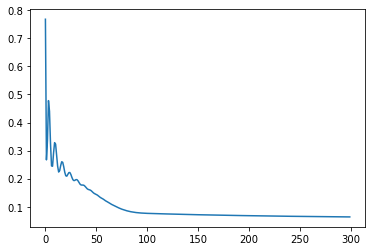

In [141]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [14]:
import xgboost as xgb
import lightgbm as lgb

## ЗАДАНИЕ II. ОСНОВНОЕ

In [6]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21
ComputeMyTaskNumber("Vakulenko_Yulia")

4

Моё задание - 4. Реализация алгоритма градиентного бустинга с логистической футкцией потерь. В качестве базового алгоритма использовать алгоритм CART (задача классификации).